# Taming text

In [16]:
%matplotlib inline
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from wordcloud import WordCloud
from PIL import Image

import nltk
import string

import pycountry

from tqdm import tqdm_notebook
import re

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1) Word cloud from the corpus

In this first part we want to extract from Mrs Clinton emails a word cloud. 

### 1.1) Data extraction

In [17]:
path = 'hillary-clinton-emails/'
emails = pd.read_csv(path + "Emails.csv")
emails.head()

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


It seems that we are provided with either the raw text file or an "attempt at extracting the body" of the message. We compare them on one instance to understand them better.

In [18]:
print(emails.head()["RawText"][1])

UNCLASSIFIED
U.S. Department of State
Case No. F-2015-04841
Doc No. C05739546
Date: 05/13/2015
STATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.
SUBJECT TO AGREEMENT ON SENSITIVE INFORMATION & REDACTIONS. NO FOIA WAIVER.
RELEASE IN
PART B6
From:
Sent:
To:
Subject:
Attachments:
B6
Thursday, March 3, 2011 9:45 PM
H: Latest How Syria is aiding Qaddafi and more... Sid
hrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx
CONFIDENTIAL
March 3, 2011
For: Hillary
From: Sid
Re: Syria aiding Qaddafi
This memo has two parts. Part one is the report that Syria is providing air support for Qaddafi. Part two is a note
to Cody from Lord David Owen, former UK foreign secretary on his views of an increasingly complex crisis. It
seems that the situation is developing into a protracted civil war with various nations backing opposing sides
with unforeseen consequences. Under these circumstances the crucial challenge is to deprive Qaddafi of his
strategic depth—his support bo

In [19]:
print(emails.head()["ExtractedBodyText"][1])

B6
Thursday, March 3, 2011 9:45 PM
H: Latest How Syria is aiding Qaddafi and more... Sid
hrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx
March 3, 2011
For: Hillary



I hate rapid conclusion but it feels as if the Extracted Body Text feature won't get us far. We thus create a new data frame to process.

In [20]:
emails_rawtext = emails["RawText"]
emails_rawtext.head()

0    UNCLASSIFIED\nU.S. Department of State\nCase N...
1    UNCLASSIFIED\nU.S. Department of State\nCase N...
2    UNCLASSIFIED\nU.S. Department of State\nCase N...
3    UNCLASSIFIED\nU.S. Department of State\nCase N...
4    B6\nUNCLASSIFIED\nU.S. Department of State\nCa...
Name: RawText, dtype: object

We finally extract the corpus

In [6]:
raw_corpus = emails_rawtext.str.cat(sep=" ")

### 1.2) Initial wordcloud

Defining the wordcloud generation

In [7]:
def generate_wordcloud(text):
    mask = np.array(Image.open("trumpmask.jpg"))
    return WordCloud(background_color="white", mask=mask).generate(text)

Plot wordcloud for raw corpus

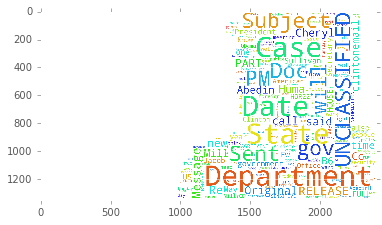

In [8]:
raw_wordcloud = generate_wordcloud(raw_corpus)
plt.imshow(raw_wordcloud)
plt.show()

### 1.3) Data processing

Defining the preprocessing pipeline

In [9]:
def preprocessing(raw, add_stopwords=[], verbose=False):
    # Tokenization
    if verbose:
        print("Tokenization...")
    punctuations = list(string.punctuation)
    tokens = nltk.word_tokenize(raw)
    tokenized = [token.lower() for token in tokens if token not in punctuations]
    
    digits = re.compile(r'[\'-.?!,":;()|0-9]')
    tokenized_nodigits = [digits.sub("", word) for word in tokenized]   
    tokenized_nodigits = list(filter(None, tokenized_nodigits)) # remove empty strings

    # Stopword removal
    if verbose:
        print("Stopword removal...")
    stop_filter = nltk.corpus.stopwords.words('english')
    stop_filter.extend(add_stopwords)
    filtered = [word for word in tokenized_nodigits if word not in stop_filter]
    
    # Lemmatisation
    if verbose:
        print("Lemmatization...")
    wnl = nltk.stem.wordnet.WordNetLemmatizer()
    #lemmatized = [wnl.lemmatize(word) for word in filtered]
    lemmatized = [wnl.lemmatize(i,j[0].lower()) if j[0].lower() in ['a','n','v'] else wnl.lemmatize(i) for i,j in nltk.pos_tag(filtered)]
 
    #Some special characters appear after lemmatizing only but it's more efficient to lemmatize on as small a corpus as possible
    return [word for word in lemmatized if word not in ["u", "``", "//", "_", "-", "say"]]
#say appears a bit too much

Preprocess corpus and save to file (**not necessary to run cell bellow since super long**)
We remove a lot of words from which we think we won't gain information: typical mail vocabulary, single letters, times (counting up to twelve is for that reason). 

In [10]:
stopwords = [
             "unclassified", "send", "state", "department", "date", "message", "state", "pm", "call", "send",             "new", "doc", "gov", "release", "part", "in", "doc", "no", "gov", "b6", "time", "original",
             "say", "from", "sent", "to", "subject", "attachments", "monday", "tuesday", "wednesday", 
             "thursday", "friday", "saturday", "sunday", "january", "february", "march", "april", "may", 
             "june", "july", "august", "september", "october", "november", "december", "case", "us",            #"us", "//",
             "stategov", "would", "cc", "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", 
             "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z", "fw", "one", "two",
             "three", "four", "five", "six", "seven", "eight", "nine", "ten", "eleven", "twelve","year", 
             "month", "week", "day", "hour", "minute", "sec"
            ]

#if you want to regenerate the processed text file, uncomment this first one. Otherwise just reload what we saved
#preprocessed_corpus = preprocessing(raw_corpus, add_stopwords=stopwords, verbose=True)
preprocessed_corpus = [line.rstrip('\n') for line in open('processed_corpus.txt')]

"""
corpus_file = open("processed_corpus.txt", 'w')
for word in preprocessed_corpus:
    corpus_file.write("%s\n" % word)
corpus_file.close()
"""

'\ncorpus_file = open("processed_corpus.txt", \'w\')\nfor word in preprocessed_corpus:\n    corpus_file.write("%s\n" % word)\ncorpus_file.close()\n'

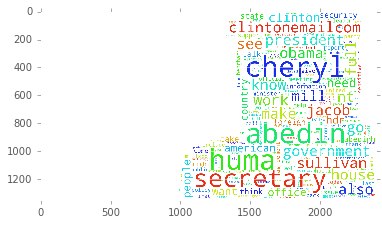

In [11]:
corpus_str = ' '.join(preprocessed_corpus)
preprocessed_wordcloud = generate_wordcloud(corpus_str)
plt.imshow(preprocessed_wordcloud)
plt.show()

They are words that appear in each email and they are not very relevant. 

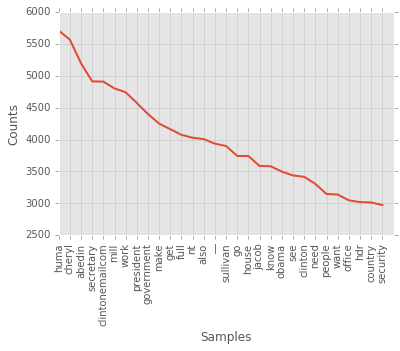

In [12]:
fd = nltk.FreqDist(preprocessed_corpus)
fd.plot(30, cumulative=False)

We indeed see that different words appear. What is not suprising, auto generated words and generic ones would appear more frequently in the non processed corpus. After preprocessing, the second most appearing token is a name: Huma Abedin. Important figure in the Democratic Party (vice chairwoman), she's nicknamed Hillary Clinton's second daughter.
https://fr.wikipedia.org/wiki/Huma_Abedin

From the two word clous, it now seems clear that without preprocessing, we could not run a precise data analysis on the corpus.

From the frequency distribution, we see that we are out of Fitz's law, since the distribution seems linear.

## Mentions of world countries in the whole corpus

Find mentions of world countries (**takes ~5 min to run**)

In [98]:
#there are 4 possible denominations, eventhough upon further reflexion, official_name is often several words so it will never match
countries = pd.DataFrame(columns=['alpha_2', 'alpha_3', 'name', 'official_name'])
country = list(pycountry.countries)[0]

for country in list(pycountry.countries):
    try:
        a3 = country.alpha_3
    except (AttributeError):
        a3 = np.nan
    try:
        offi = country.official_name
    except (AttributeError):
        offi = np.nan
    countries.loc[country.numeric] = [country.alpha_2, a3, country.name, offi]
countries = countries.apply(lambda x: x.str.lower())    

def country_mentions(text):
    matches = []
    #mask here is a data frame of boolean values
    mask = countries.isin(text)
    indices = mask[mask.any(axis=1)].index.values
    country_mentions = countries.loc[indices]["name"]
        
    return country_mentions

We want to apply the preprocessing function to each email separately

In [62]:
Processed_Text = emails["RawText"].apply(lambda x: preprocessing(x, add_stopwords=stopwords))

In [64]:
import nltk.sentiment
sid = nltk.sentiment.vader.SentimentIntensityAnalyzer()

def sentiment_polarity(sentence):
    return sid.polarity_scores(sentence)["compound"]


In [65]:
sentiment_polarity("I feel great today. Hail Trump!")

0.69

In [66]:
sentiment = pd.Series([])
mentions = pd.Series([])

def build_sentiment_matrix(Processed_Text):
    for i in range(len(Processed_Text)):
            mentions_list = country_mentions(Processed_Text[i])
            text_local = ' '.join(Processed_Text[i])
            sentiment_local = sentiment_polarity(text_local)
            if i%500 == 0:
                print(i)
            for j in range(len(mentions_list)):
                mentions[len(mentions)+1] = mentions_list[j]
                sentiment[len(sentiment)+1] = sentiment_local
    return pd.concat([sentiment, mentions], axis=1)#.reset_index()

In [114]:
#sentiment_matrix = build_sentiment_matrix(Processed_Text)
#sentiment_matrix.to_csv('sentiment_matrix')
sentiment_matrix = pd.read_csv("sentiment_matrix", index_col=0)


In [120]:
#tqdm_notebook().pandas(desc="Computing polarity")
#polarities = emails_rawtext.progress_apply(sentiment_polarity)
#sentiment_matrix.to_csv('sentiment_matrix')

sentiment_matrix.columns = ["sentiment", "country"]
sentiment_by_country = sentiment_matrix.groupby("country").mean()


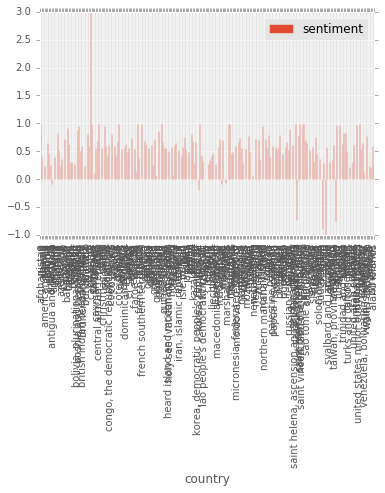

In [126]:
sentiment_by_country.plot.bar()